In [14]:
import os
from itertools import product

import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [15]:
CSV_PATH = "/home/28i_mel@lab.graphicon.ru/mnt/dione/28i_mel/Linearity-results/"
get_base_line = lambda dataset, iter: f"{dataset}_resnet101+relu_PGD={iter}.csv"
sns.set_color_codes('deep')
sns.set_theme()

In [35]:
activations = [
    "relu",
    "Frelu_elu",
]
archs = [
    "resnet101",
    "vonenet50",
]
prunes = [ 
    {
        'percent': .0,
        'method': '',
    }, 
    {
        'percent': .1,
        'method': 'pls',
    },
    {
        'percent': .1,
        'method': 'l1',
    },
    {
        'percent': .1,
        'method': 'l2',
    }
]
cayley = [
    True,
    False
]
cayley_pool = [
    True,
    False
]
cayley_pair = [
    True,
    False
]
gradnorm = [
    True,
    False
]

datasets = ["NIPS", "KonIQ-10k"]

In [36]:
available_results = os.listdir(CSV_PATH)

In [37]:
class Scores:
    def __init__(self, **kwargs):
        self.nips_df, self.koniq_df = kwargs.get("nips_df", None), kwargs.get("koniq_df", None)
        self.iters = kwargs.get("iters", 1)
    def _fit(self, col):
        if self.nips_df is not None:
            self.beta0_nips = self.nips_df[col].min()
            self.beta1_nips = self.nips_df[col].max()
        if self.koniq_df is not None:
            self.beta0_koniq = self.koniq_df[col].min()
            self.beta1_koniq = self.koniq_df[col].max()

    def get_abs_gain(self, clear_val, attacked_val):
        return (attacked_val-clear_val).mean()

    def get_r_score(self, clear_val, attacked_val, dataset='NIPS', col='clear_val'):
        self._fit(col)
        if isinstance(clear_val, pd.DataFrame) or isinstance(clear_val, pd.Series):
            clear_val = clear_val.to_numpy()
        if isinstance(attacked_val, pd.DataFrame) or isinstance(attacked_val, pd.Series):
            attacked_val = attacked_val.to_numpy()
        if dataset=='NIPS' or self.nips_df is not None:
            beta1 = self.beta1_nips
            beta0 = self.beta0_nips
        elif dataset=='KonIQ-10k' or self.koniq_df is not None:
            beta1 = self.beta1_koniq
            beta0 = self.beta0_koniq
        return np.mean(np.log10(np.maximum(beta1-attacked_val, clear_val-beta0)/np.abs(attacked_val-clear_val)))

In [38]:
epsilons = [ 2, 4, 6, 8, 10 ]
attack_type = "PGD"
iterations = 1

In [40]:
baseline_df_nips = pd.read_csv(os.path.join(CSV_PATH, get_base_line('NIPS', 1)))
baseline_df_koniq = pd.read_csv(os.path.join(CSV_PATH, get_base_line('KonIQ-10k', 1)))
scores = Scores(nips_df=baseline_df_nips, koniq_df=baseline_df_koniq)

baseLine = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
for i, df in enumerate((baseline_df_nips, baseline_df_koniq,)):
    for eps in epsilons:
        baseLine.loc[len(baseLine)] = {
                                    'eps': f"{eps}/255",
                                    'abs_gain': 
                                        scores.get_abs_gain(df['clear_val'], 
                                                            df[f'attacked_val_eps={eps}']),
                                    'r_score': 
                                        scores.get_r_score(df['clear_val'], 
                                                           df[f'attacked_val_eps={eps}'], 
                                                           dataset=datasets[i],
                                                           col=f'attacked_val_eps={eps}'),
                                    'dataset': datasets[i]
                                    }

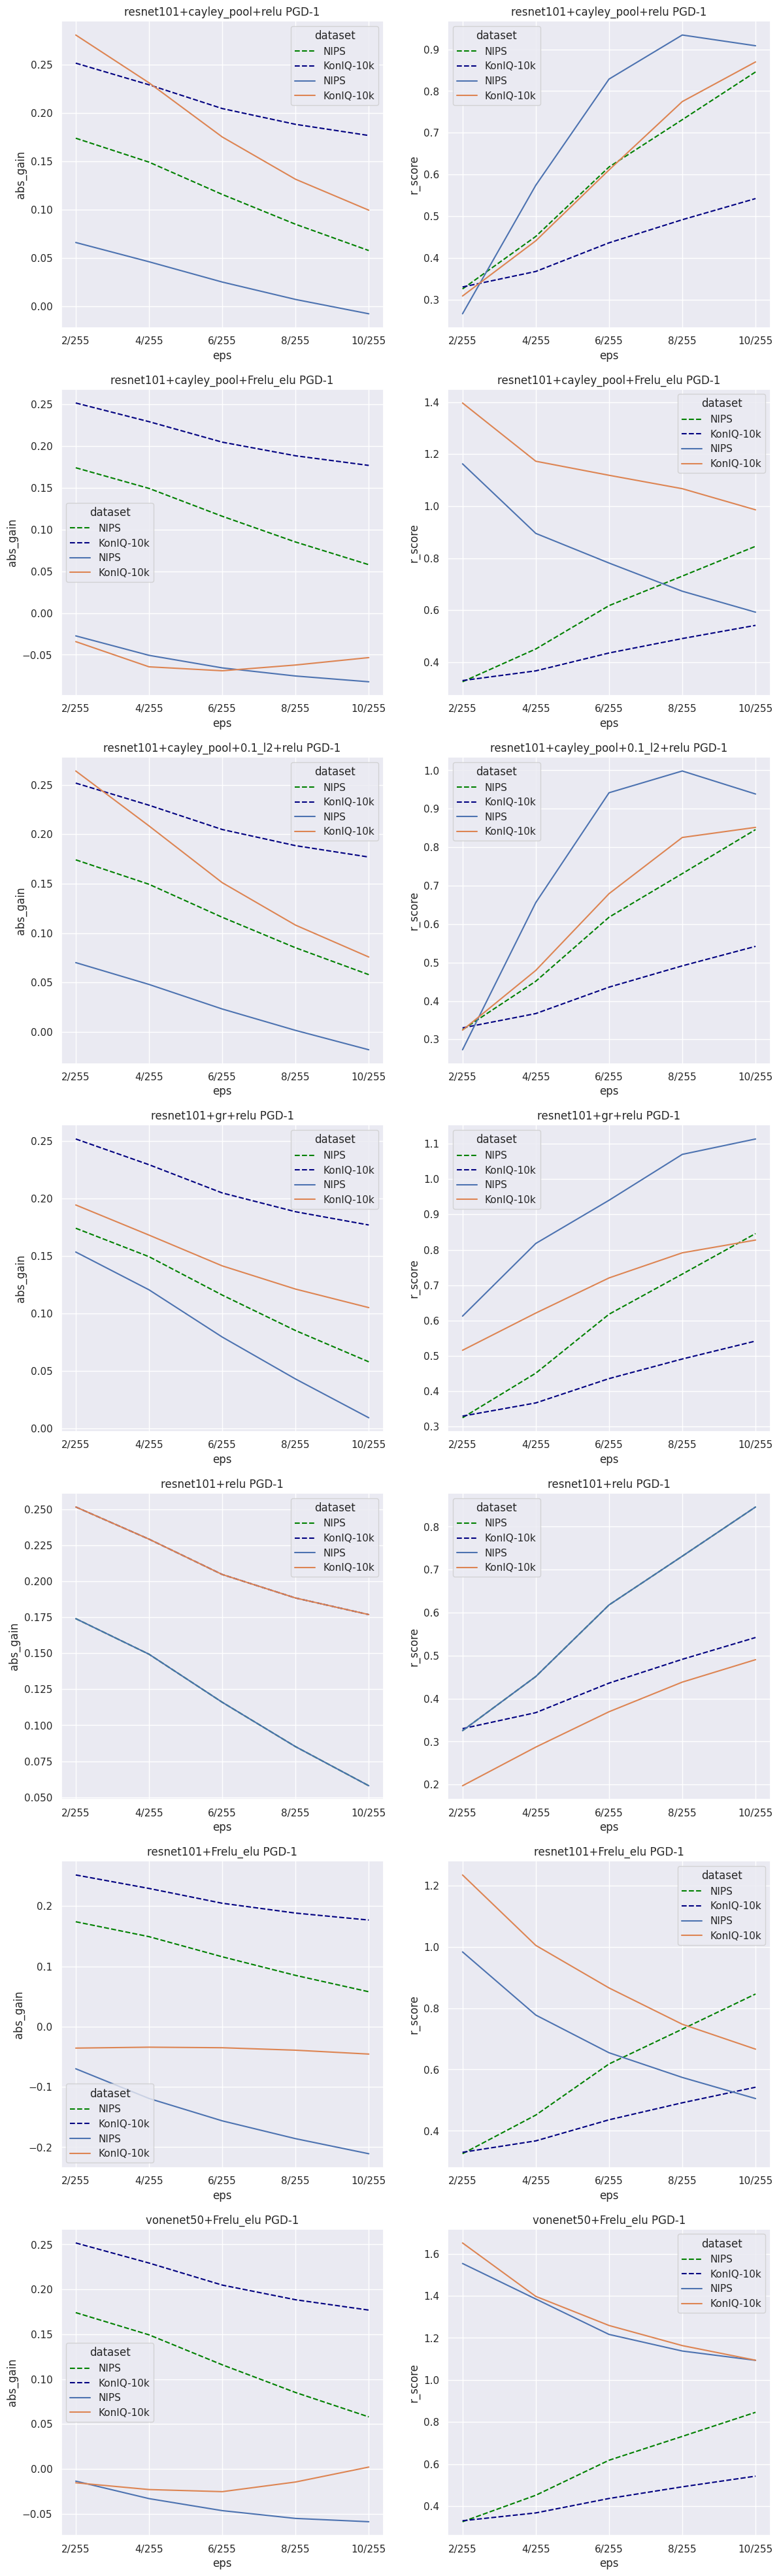

In [41]:

fig, axis = plt.subplots(7, 2, figsize=(14,50), sharey=False)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
# axis = axis.flatten()
plot_idx = 0

arch_title = None

for (
     # dataset, 
     is_cayley, 
     is_cayley_pool, 
     is_cayley_pair,
     is_gradnorm_regularization,
     prune,
     arch,
     activation) in product(
                    # datasets, 
                    cayley, 
                    cayley_pool, 
                    cayley_pair, 
                    gradnorm,
                    prunes,
                    archs,
                    activations):
     data = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
     # abs_gain = {}
     for dataset in datasets:
          cl = f'+cayley' if is_cayley else ''
          clp = f'+cayley_pool' if is_cayley_pool else ''
          cp = f'+cayley_pair' if is_cayley_pair else ''
          gr = f'+gr' if is_gradnorm_regularization else ''
          prune_status = f"+{prune['percent']}_{prune['method']}" if prune['percent'] else ''
          arch_status = f'{arch}{cl}{clp}{cp}{gr}{prune_status}+{activation}'
          path = "{}_{}_{}={}.csv".format(
                                        dataset,
                                        arch_status,
                                        attack_type,
                                        iterations
                                        )
          # print(path)
          if path not in available_results:
               break
          # print(path)
          path = os.path.join(CSV_PATH, path)
          df = pd.read_csv(path, index_col=False)
          
          if dataset=='NIPS':
               scores = Scores(nips_df=df)
          elif dataset=='KonIQ-10k':
               scores = Scores(koniq_df=df)

          arch_title = f"{arch_status} {attack_type}-{iterations}"
          for eps in epsilons:
               data.loc[len(data)] = {
                    'eps': f'{int(eps)}/255',
                    'abs_gain': scores.get_abs_gain(df['clear_val'], 
                                                    df[f'attacked_val_eps={eps}']),
                    'r_score': scores.get_r_score(df['clear_val'], 
                                                  df[f'attacked_val_eps={eps}'], 
                                                  dataset=dataset, 
                                                  col=f'attacked_val_eps={eps}'),
                    'dataset': dataset,
               }
     
     if len(data) > 0:
          sns.lineplot(data=baseLine, x='eps', y='abs_gain', palette=[(0,0.5,0), (0,0,0.5)], linewidth=1.5, linestyle='--',
                       legend='full', hue='dataset', ax=axis[plot_idx][0]
                       )
          sns.lineplot(data=data, x='eps', y='abs_gain', 
                       legend="full", hue="dataset", ax=axis[plot_idx][0])
          
          sns.lineplot(data=baseLine, x='eps', y='r_score', palette=[(0,0.5,0), (0,0,0.5)], linewidth=1.5, linestyle='--',
                       legend='full', hue='dataset', ax=axis[plot_idx][1]
                       )
          sns.lineplot(data=data, x='eps', y='r_score', 
                       legend="full", hue="dataset", ax=axis[plot_idx][1])
          axis[plot_idx][0].set_title(arch_title)
          axis[plot_idx][1].set_title(arch_title)
          plot_idx += 1

plt.show()

In [45]:
epsilons = [ 2, 4, 6, 8, 10 ]
attack_type = "PGD"
iterations = 3

In [46]:
baseline_df_nips = pd.read_csv(os.path.join(CSV_PATH, get_base_line('NIPS', 1)))
baseline_df_koniq = pd.read_csv(os.path.join(CSV_PATH, get_base_line('KonIQ-10k', 1)))
scores = Scores(nips_df=baseline_df_nips, koniq_df=baseline_df_koniq)

baseLine = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
for i, df in enumerate((baseline_df_nips, baseline_df_koniq,)):
    for eps in epsilons:
        baseLine.loc[len(baseLine)] = {
                                    'eps': f"{eps}/255",
                                    'abs_gain': 
                                        scores.get_abs_gain(df['clear_val'], 
                                                            df[f'attacked_val_eps={eps}']),
                                    'r_score': 
                                        scores.get_r_score(df['clear_val'], 
                                                           df[f'attacked_val_eps={eps}'], 
                                                           dataset=datasets[i], 
                                                           col=f'attacked_val_eps={eps}'),
                                    'dataset': datasets[i]
                                    }

/tmp/ipykernel_1480381/2555767501.py:28: RuntimeWarning: divide by zero encountered in log10
  return np.mean(np.log10(np.maximum(beta1-attacked_val, clear_val-beta0)/np.abs(attacked_val-clear_val)))


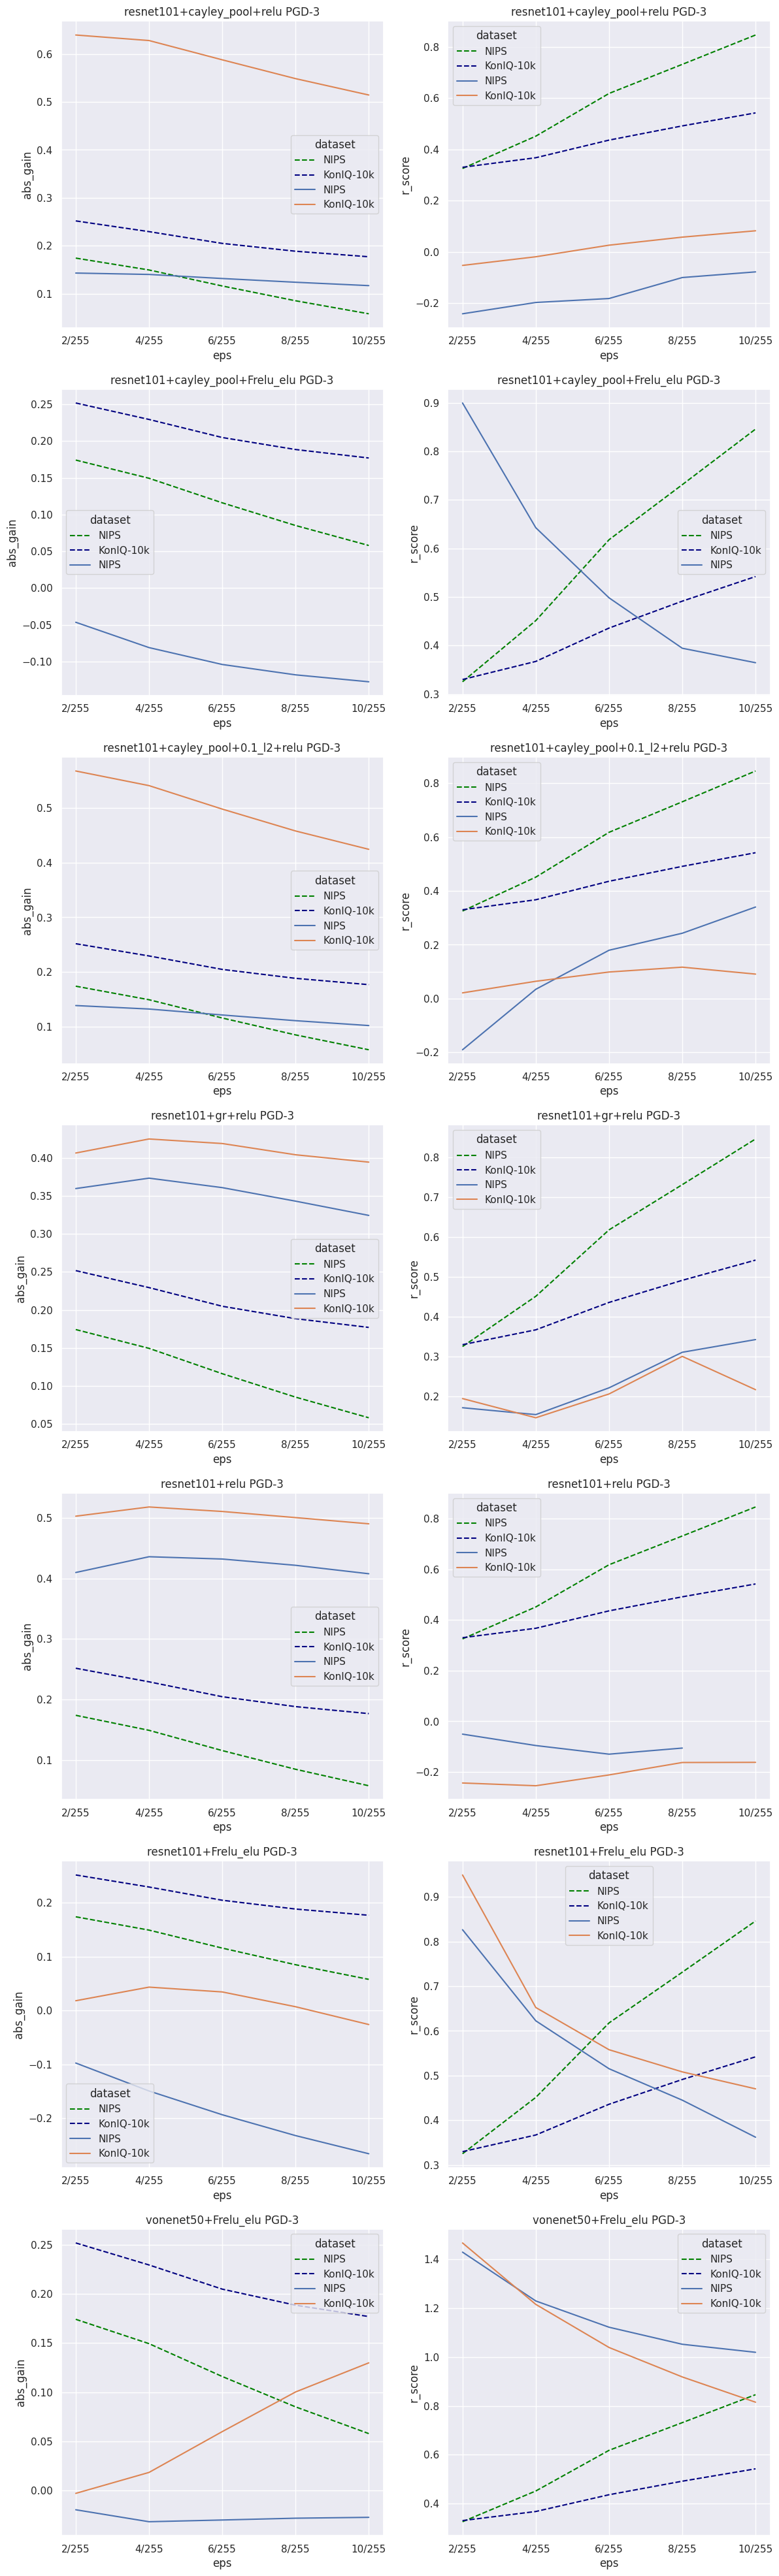

In [47]:

fig, axis = plt.subplots(7, 2, figsize=(14,50), sharey=False)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
# axis = axis.flatten()
plot_idx = 0

arch_title = None

for (
     # dataset, 
     is_cayley, 
     is_cayley_pool, 
     is_cayley_pair,
     is_gradnorm_regularization,
     prune,
     arch,
     activation) in product(
                    # datasets, 
                    cayley, 
                    cayley_pool, 
                    cayley_pair, 
                    gradnorm,
                    prunes,
                    archs,
                    activations):
     data = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
     # abs_gain = {}
     for dataset in datasets:
          cl = f'+cayley' if is_cayley else ''
          clp = f'+cayley_pool' if is_cayley_pool else ''
          cp = f'+cayley_pair' if is_cayley_pair else ''
          gr = f'+gr' if is_gradnorm_regularization else ''
          prune_status = f"+{prune['percent']}_{prune['method']}" if prune['percent'] else ''
          arch_status = f'{arch}{cl}{clp}{cp}{gr}{prune_status}+{activation}'
          path = "{}_{}_{}={}.csv".format(
                                        dataset,
                                        arch_status,
                                        attack_type,
                                        iterations
                                        )
          # print(path)
          if path not in available_results:
               break
          # print(path)
          path = os.path.join(CSV_PATH, path)
          df = pd.read_csv(path, index_col=False)
          
          if dataset=='NIPS':
               scores = Scores(nips_df=df)
          elif dataset=='KonIQ-10k':
               scores = Scores(koniq_df=df)

          arch_title = f"{arch_status} {attack_type}-{iterations}"
          for eps in epsilons:
               data.loc[len(data)] = {
                    'eps': f'{int(eps)}/255',
                    'abs_gain': scores.get_abs_gain(df['clear_val'], 
                                                    df[f'attacked_val_eps={eps}']),
                    'r_score': scores.get_r_score(df['clear_val'], 
                                                  df[f'attacked_val_eps={eps}'], 
                                                  dataset=dataset, 
                                                  col=f'attacked_val_eps={eps}'),
                    'dataset': dataset,
               }
     
     if len(data) > 0:
          sns.lineplot(data=baseLine, x='eps', y='abs_gain', palette=[(0,0.5,0), (0,0,0.5)], linewidth=1.5, linestyle='--',
                       legend='full', hue='dataset', ax=axis[plot_idx][0]
                       )
          sns.lineplot(data=data, x='eps', y='abs_gain', 
                       legend="full", hue="dataset", ax=axis[plot_idx][0])
          
          sns.lineplot(data=baseLine, x='eps', y='r_score', palette=[(0,0.5,0), (0,0,0.5)], linewidth=1.5, linestyle='--',
                       legend='full', hue='dataset', ax=axis[plot_idx][1]
                       )
          sns.lineplot(data=data, x='eps', y='r_score', 
                       legend="full", hue="dataset", ax=axis[plot_idx][1])
          axis[plot_idx][0].set_title(arch_title)
          axis[plot_idx][1].set_title(arch_title)
          plot_idx += 1

plt.show()

In [49]:
epsilons = [ 2, 4, 6, 8, 10 ]
attack_type = "PGD"
iterations = 5

In [50]:
baseline_df_nips = pd.read_csv(os.path.join(CSV_PATH, get_base_line('NIPS', 1)))
baseline_df_koniq = pd.read_csv(os.path.join(CSV_PATH, get_base_line('KonIQ-10k', 1)))
scores = Scores(nips_df=baseline_df_nips, koniq_df=baseline_df_koniq)

baseLine = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
for i, df in enumerate((baseline_df_nips, baseline_df_koniq,)):
    for eps in epsilons:
        baseLine.loc[len(baseLine)] = {
                                    'eps': f"{eps}/255",
                                    'abs_gain': 
                                        scores.get_abs_gain(df['clear_val'], 
                                                            df[f'attacked_val_eps={eps}']),
                                    'r_score': 
                                        scores.get_r_score(df['clear_val'], 
                                                           df[f'attacked_val_eps={eps}'], 
                                                           dataset=datasets[i], 
                                                           col=f'attacked_val_eps={eps}'),
                                    'dataset': datasets[i]
                                    }

/tmp/ipykernel_1480381/2555767501.py:28: RuntimeWarning: divide by zero encountered in log10
  return np.mean(np.log10(np.maximum(beta1-attacked_val, clear_val-beta0)/np.abs(attacked_val-clear_val)))
/tmp/ipykernel_1480381/2555767501.py:28: RuntimeWarning: divide by zero encountered in log10
  return np.mean(np.log10(np.maximum(beta1-attacked_val, clear_val-beta0)/np.abs(attacked_val-clear_val)))
/tmp/ipykernel_1480381/2555767501.py:28: RuntimeWarning: divide by zero encountered in log10
  return np.mean(np.log10(np.maximum(beta1-attacked_val, clear_val-beta0)/np.abs(attacked_val-clear_val)))
/tmp/ipykernel_1480381/2555767501.py:28: RuntimeWarning: divide by zero encountered in log10
  return np.mean(np.log10(np.maximum(beta1-attacked_val, clear_val-beta0)/np.abs(attacked_val-clear_val)))
/tmp/ipykernel_1480381/2555767501.py:28: RuntimeWarning: divide by zero encountered in log10
  return np.mean(np.log10(np.maximum(beta1-attacked_val, clear_val-beta0)/np.abs(attacked_val-clear_val)))


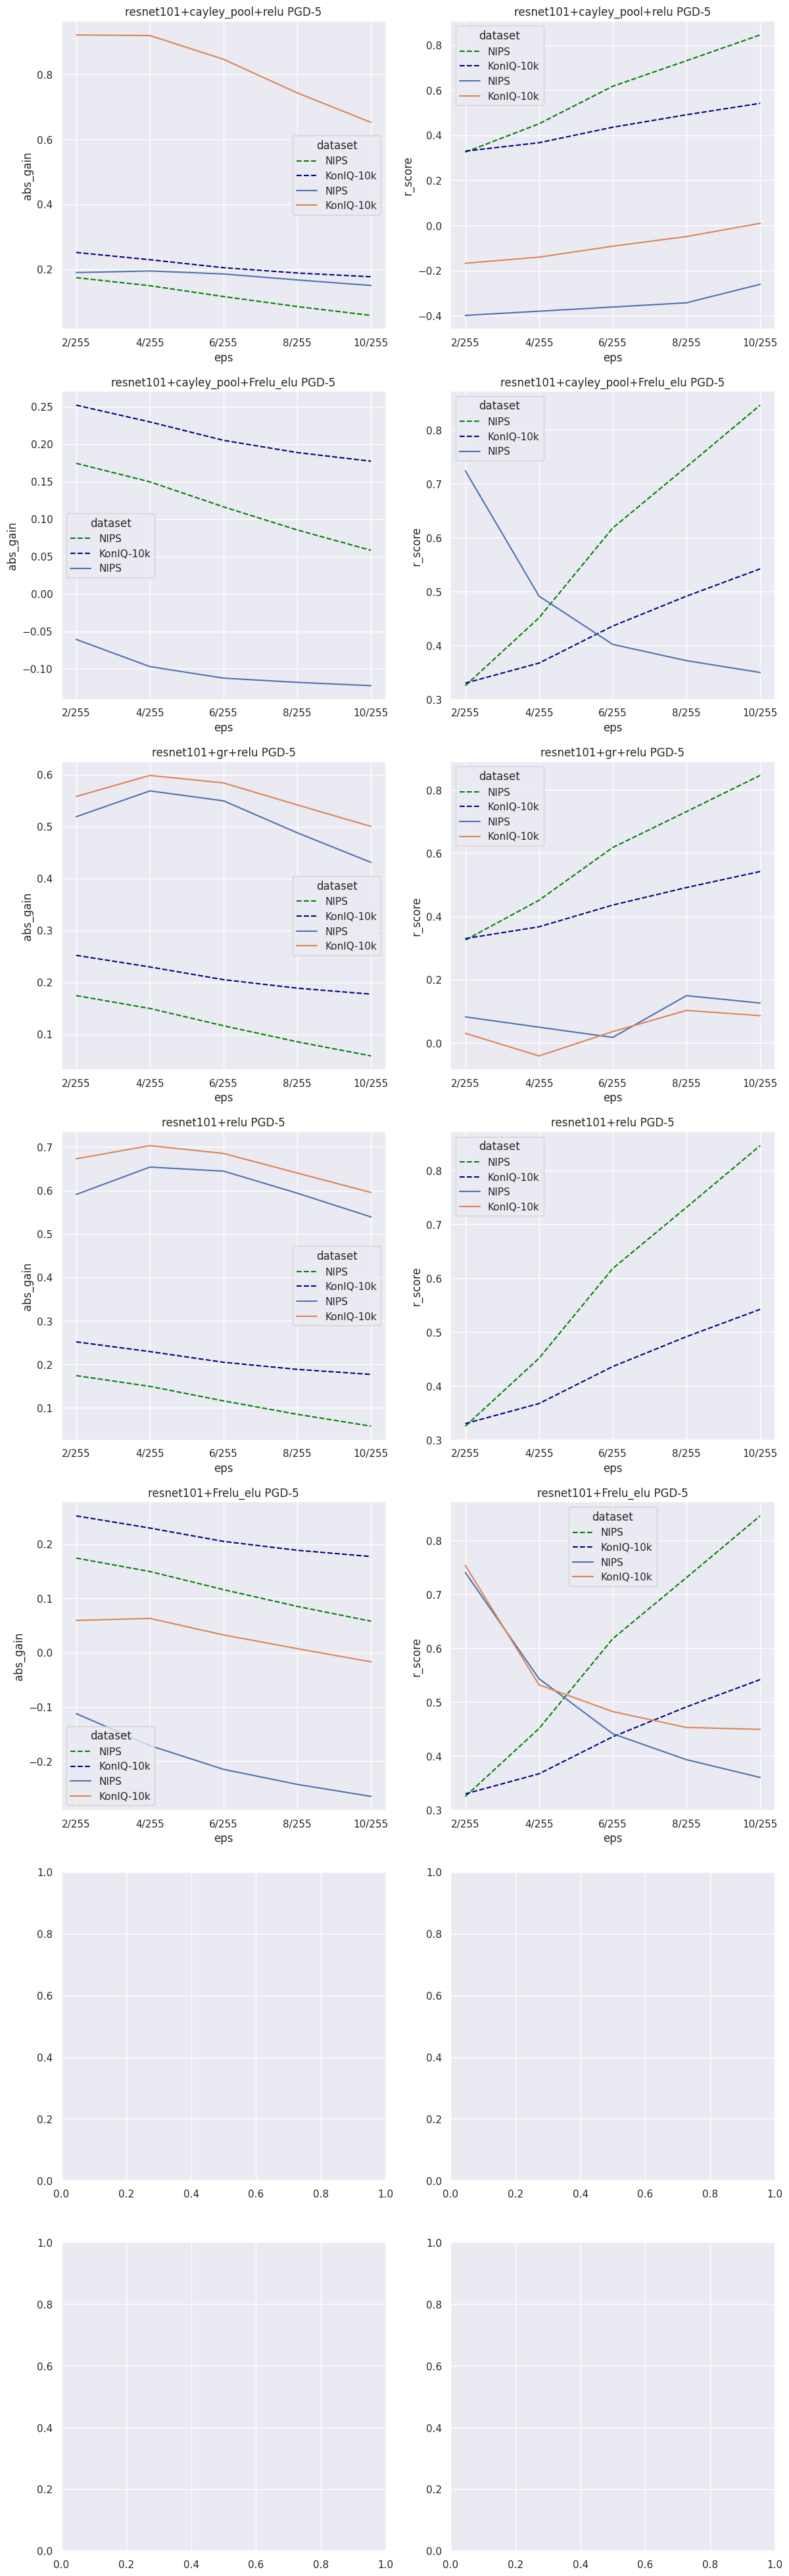

In [51]:

fig, axis = plt.subplots(7, 2, figsize=(14,50), sharey=False)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
# axis = axis.flatten()
plot_idx = 0

arch_title = None

for (
     # dataset, 
     is_cayley, 
     is_cayley_pool, 
     is_cayley_pair,
     is_gradnorm_regularization,
     prune,
     arch,
     activation) in product(
                    # datasets, 
                    cayley, 
                    cayley_pool, 
                    cayley_pair, 
                    gradnorm,
                    prunes,
                    archs,
                    activations):
     data = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
     # abs_gain = {}
     for dataset in datasets:
          cl = f'+cayley' if is_cayley else ''
          clp = f'+cayley_pool' if is_cayley_pool else ''
          cp = f'+cayley_pair' if is_cayley_pair else ''
          gr = f'+gr' if is_gradnorm_regularization else ''
          prune_status = f"+{prune['percent']}_{prune['method']}" if prune['percent'] else ''
          arch_status = f'{arch}{cl}{clp}{cp}{gr}{prune_status}+{activation}'
          path = "{}_{}_{}={}.csv".format(
                                        dataset,
                                        arch_status,
                                        attack_type,
                                        iterations
                                        )
          # print(path)
          if path not in available_results:
               break
          # print(path)
          path = os.path.join(CSV_PATH, path)
          df = pd.read_csv(path, index_col=False)
          
          if dataset=='NIPS':
               scores = Scores(nips_df=df)
          elif dataset=='KonIQ-10k':
               scores = Scores(koniq_df=df)

          arch_title = f"{arch_status} {attack_type}-{iterations}"
          for eps in epsilons:
               data.loc[len(data)] = {
                    'eps': f'{int(eps)}/255',
                    'abs_gain': scores.get_abs_gain(df['clear_val'], 
                                                    df[f'attacked_val_eps={eps}']),
                    'r_score': scores.get_r_score(df['clear_val'], 
                                                  df[f'attacked_val_eps={eps}'], 
                                                  dataset=dataset, 
                                                  col=f'attacked_val_eps={eps}'),
                    'dataset': dataset,
               }
     
     if len(data) > 0:
          sns.lineplot(data=baseLine, x='eps', y='abs_gain', palette=[(0,0.5,0), (0,0,0.5)], linewidth=1.5, linestyle='--',
                       legend='full', hue='dataset', ax=axis[plot_idx][0]
                       )
          sns.lineplot(data=data, x='eps', y='abs_gain', 
                       legend="full", hue="dataset", ax=axis[plot_idx][0])
          
          sns.lineplot(data=baseLine, x='eps', y='r_score', palette=[(0,0.5,0), (0,0,0.5)], linewidth=1.5, linestyle='--',
                       legend='full', hue='dataset', ax=axis[plot_idx][1]
                       )
          sns.lineplot(data=data, x='eps', y='r_score', 
                       legend="full", hue="dataset", ax=axis[plot_idx][1])
          axis[plot_idx][0].set_title(arch_title)
          axis[plot_idx][1].set_title(arch_title)
          plot_idx += 1

plt.show()